# 4. PyTorch Custom Datasets

## 0. Importing pytorch and setting-up device agnostic code

In [52]:
import torch
from torch import nn

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get some Data

- The dataset we will be using is a subset of Food101 dataset
- Food101 has 101 classes and 1000 images per class(750 training and 250 testing)
- Our dataset starts with 3 classes of food and only 10% of the images

In [54]:
import requests
from pathlib import Path
import zipfile
import os

data_path = Path("./data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} dir already exists... skipping dowload")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# downloading the data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)


data/pizza_steak_sushi dir already exists... skipping dowload
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data(data exploration and preparation)

In [55]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [56]:
walk_through_dir(data_path)

There are 1 directories and 1 images in 'data'.
There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [57]:
# setup train and testing paths

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/steak/3518960.jpg
Image class: steak
Image height: 512
Image width: 384


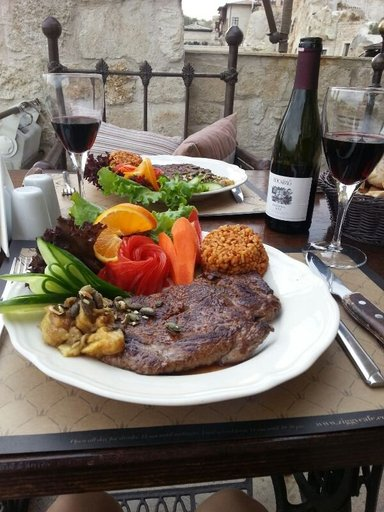

In [58]:
import random
from PIL import Image

#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
# 2. pick a rando image path
random_image_path = random.choice(image_path_list)
#print(random_image_path)

# get the image class from path name
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### 2.2 Visualize using matplotlib

(-0.5, 383.5, 511.5, -0.5)

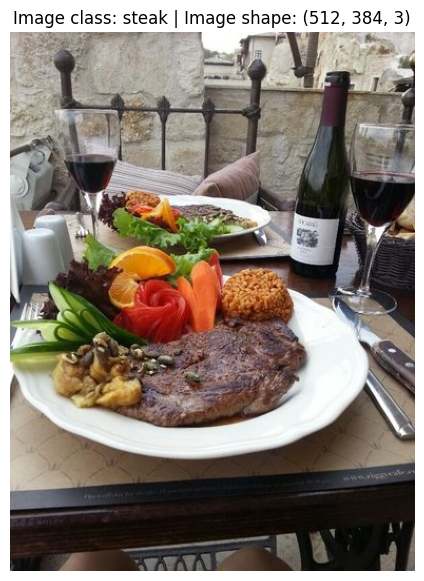

In [59]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

## 3. Transform the Data

- Firstly, we convert the images to pytorch tensors
- Then, we turn it into a torch.utils.data.Dataset followed by transforming to DataLoader

In [60]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming with torchvision.transforms

In [61]:
# write a transform for image
data_transform = transforms.Compose([
    # resize to 64x64
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a tensor
    transforms.ToTensor()
])

In [62]:
data_transform(img).dtype


torch.float32

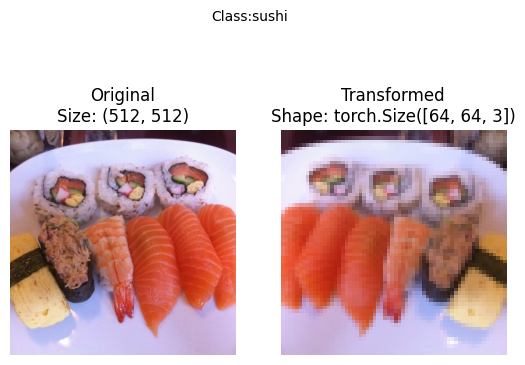

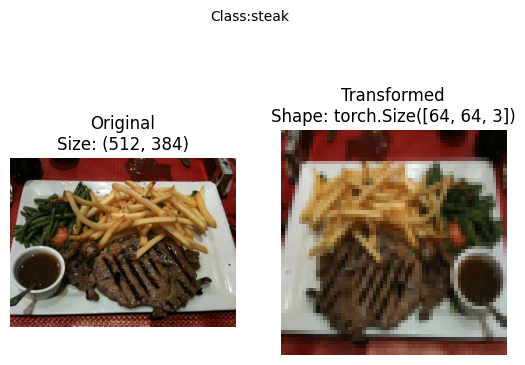

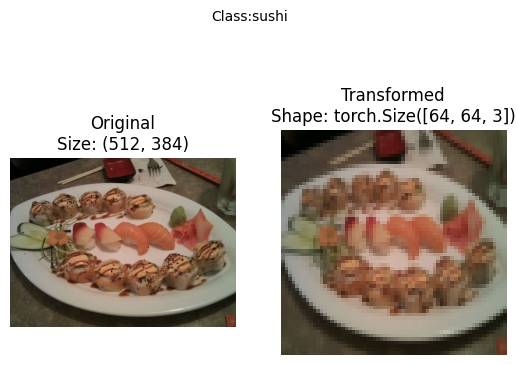

In [63]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax=plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # transform an plot target image
            transformed_image = transform(f).permute(1,2,0) # c,h,w -> h,w,c
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class:{image_path.parent.stem}", fontsize=10)

plot_transformed_images(image_path_list,data_transform,3)

## 4. Option 1: Loading images using image folder

We can load image classification data using ImageFolder

In [64]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None # transform the label
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [65]:
class_names = train_data.classes
print(class_names)

class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [66]:
# index on the train_data to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:{img.shape}")
print(f"Image dataype:{img.dtype}")
print(f"Image Label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [c,h,w]
Image permute: torch.Size([64, 64, 3]) -> [h,w,c]


Text(0.5, 1.0, 'pizza')

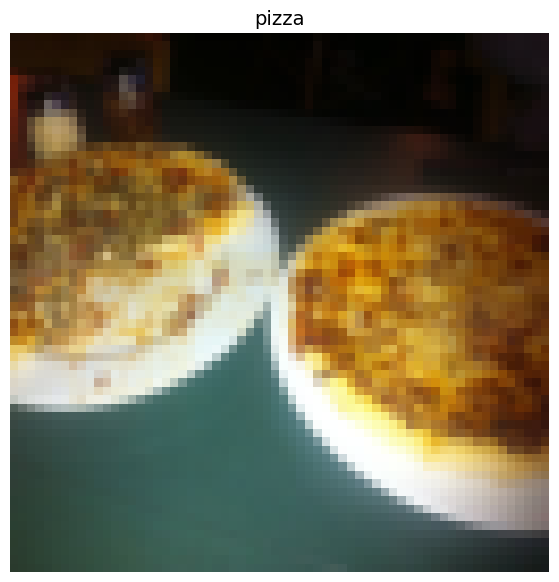

In [67]:
# rearrange the order dimensions
img_permute = img.permute(1,2,0)

# print out different shapes

print(f"Original shape: {img.shape} -> [c,h,w]")
print(f"Image permute: {img_permute.shape} -> [h,w,c]")

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our dataset into iterable batches so our model can load images at a time.

In [68]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
import os
BATCH_SIZE=1
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f015ffeb990>,
 <torch.utils.data.dataloader.DataLoader at 0x7f015ff826d0>)

In [69]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [70]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## 5 Option 2: Loading image with a custom Dataset class

- load images from files
- get class names
- get classes as dictionary from the Dataset

Pros:

* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-built Dataset functions

Cons:
* Can be prone to more erros

**We will subclass Dataset class and do this task**

In [71]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [72]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create a helper function to get the classs names

- get class names using os.scandir()
- class_names to class_dict

In [73]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = os.scandir(target_directory) # returns an iterable
class_names_found = sorted([entry.name for entry in list(class_names_found)])

class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [74]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:


    # 1. get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Please check the {directory} structure")

    # 3. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx


In [75]:
class_names, class_to_idx = find_classes(directory=train_dir)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

To create our own custom dataset, we want to:

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:

- paths - paths of our images
- transform - the transform we'd like to use
- classes - a list of the target classes
- class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images(), this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [75]:
class CustomDataset(Dataset):
    def __init__(self):
        super().__init__()
